## Домашняя работа по современным сверточным нейросетям

### Эксперименты

Так как в обучении нейросетевой модели есть очень много различных гиперпараметров, в данном задании нужно будет делать много различных экспериментов. И будет очень полезно, и для вас самих, и для нас, проверяющих, наличие текстового описания всех, или по крайней мере самых интересных/важных в выборе итоговой модели, экспериментов с результатами в финальном ноутбуке. Наличие и подробность описания экспериментов будут входить в итоговую оценку за домашнее задание. Дедлайн на Kaggle специально поставлен немного раньше, чтобы у вас было время спокойно дописать отчет об экспериментах.

## Установка окружения

In [ ]:
from IPython.display import clear_output
from google.colab import drive


!pip install wandb
!wandb login

drive.mount('/content/drive')
%cd /content/drive/MyDrive/collab_sandbox/Sirius/


clear_output()
!ls

artifacts    data		       models	    wandb
checkpoints  HW0_cnn_pytorch_pr.ipynb  predictions


## Решение

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output

In [ ]:
import os
import pickle
from typing import Any, Callable, Optional, Tuple
from PIL import Image

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.transforms import ToTensor, Compose
from torchvision.datasets.vision import VisionDataset
import torchvision.transforms as T

In [ ]:
# !pip install albumentations
# # albumentations error fix
# !pip install opencv-python-headless==4.1.2.30

!pip install -U albumentations

In [ ]:
import wandb
from datetime import datetime
import shutil
import importlib
from importlib.machinery import SourceFileLoader
import albumentations as A

Код для загрузки измененного датасета SVHN. Аргументы инициализации:

- `root` — строка, путь до директории с файлами датасета
- `is_train` — флаг, загружать часть для обучения или теста
- `transform` — преобразования изображения
- `target_transform` — преобразования класса изображения

In [ ]:
dataset_root = "data/"

class SVHN(VisionDataset):

    def __init__(self,
                 root: str,
                 is_train: bool = True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)
        self.is_train = is_train

        meta_path = os.path.join(self.root, 'meta')
        with open(meta_path, "rb") as f:
            content = pickle.load(f)
            self.classes = content['label_names']
            self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

        data_path = os.path.join(self.root, 'data_train' if is_train else 'data_test')
        with open(data_path, "rb") as f:
            content = pickle.load(f)
            self.data = content['images']
            self.targets = content.get('labels')

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.fromarray(self.data[index].astype(np.uint8))
        target = self.targets[index] if self.is_train else len(self.classes)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.data)
        
    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

я не хотел трогать оригинальный датасет, поэтому написал надстройку, чтобы ничего не сломать

In [ ]:
class SVHNTrain(Dataset):

    def __init__(self,
            transform=None, 
            target_transform=None,
            initial_dataset=None,
        ):

        super().__init__()
        self.initial_dataset = initial_dataset
        self.transform = transform

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img, target = self.initial_dataset[index]
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, target

    def __len__(self) -> int:
        return len(self.initial_dataset)

### Загрузка датасета

В целом скажу что без аугментации максимум можно достичь 94.5, аугментация в виде растяжения, поворота, сдвига на моем личном опыте дала до 2 процентов.

(наблюдение)
Если не выполнять аугментацию, то для того чтобы модель не переобучалось необходимо добавлять дропаут. Если же использовать аугментацию, то от дропаута можно избавиться вовсе.

Загружаем часть датасета для обучения.

In [ ]:
data = SVHN(
    root=dataset_root,
    is_train=True,
)


train_data, val_data = torch.utils.data.random_split(
    data, 
    [40000, 10000], 
    generator=torch.Generator().manual_seed(228),
)



train_data = SVHNTrain(
    transform=T.Compose([
        ToTensor(),
        T.RandomAffine(
            25, 
            # translate=(0.05, 0.1), 
            scale=(0.9, 1.2), 
            shear=25
        ),
    ]),
    initial_dataset=train_data
)

val_data = SVHNTrain(
    transform=T.Compose([
        ToTensor(),              
    ]),
    initial_dataset=val_data
)

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, )

test_data = SVHN(
    root=dataset_root,
    is_train=False,
    transform=T.Compose([
        ToTensor(),          
    ]),
)

test_dataloader = DataLoader(
    test_data, 
    batch_size=batch_size,
)

Посмотрим, какой размерности батчи выдает data loader.

In [ ]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape, X.dtype, X.device)
    print("Shape of y: ", y.shape, y.dtype, y.device)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 32, 32]) torch.float32 cpu
Shape of y:  torch.Size([64]) torch.uint8 cpu


### Обязательно смотрим на наши данные

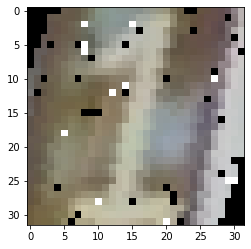

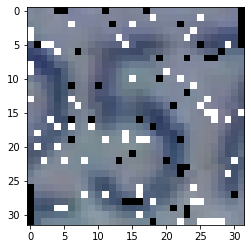

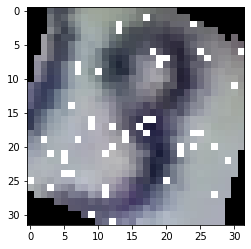

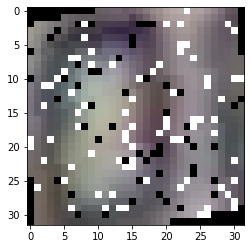

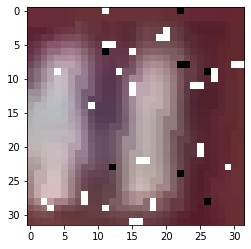

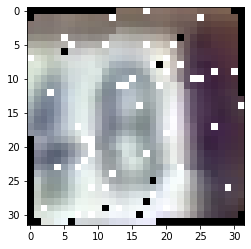

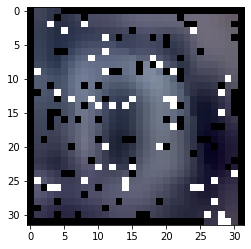

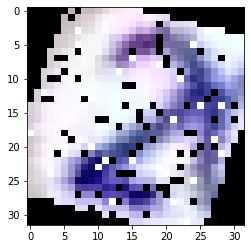

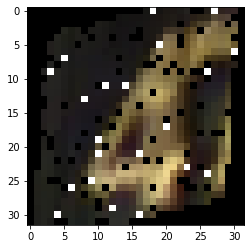

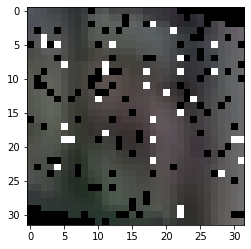

In [ ]:
from matplotlib import pyplot as plt
# val_dataloader
for X, y in train_dataloader:
    for i in range(10):
        image_data = X[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(image_data, interpolation='nearest')
        plt.show()
    break

Сначала я не посмотрел на то КАК выглядят данные для человека, поэтому использовал по стандарту MaxPool, но после того как увидел что этот слой может работать некорректно из-за того что мы имеем белый шум, изменил его на Average, это улучшило модели до 5%.

# Сначала перепишем тренировочный цикл в один класс, чтобы было удобнее перезапускать эксперименты

Пока я выполнял задание я использовал платформу wandb. Ранее я только знал что на ней можно визуализировать метрики, но потом оказалось что она способна сохранять любые файлы и модели и привязывать их к имени запуска.

После этого родился этот мини-фреймворк. Я не знаю, может подобная библиотека уже существует, но мне не известно о ней.

Результаты тренировок и графики можно посмотреть тут https://wandb.ai/dimweb/sirius_test?workspace=user-dimweb

Но это еще не все, данный сервис можно превратить в github но с моделями. Например я внес какие-то изменения, написал об этом и отправил на тренировку. После этого в разделе artifacts можно посмотреть все использованные параметры и небольшое описание об изменениях. Под конец я конечно стал пренебрегать описанием, но просто хотелось больше попробовать под конец(неловко).

Также при каждом запуске сохраняется **весь ноутбук**, **код модели** и **веса модели**. Поэтому после того как наконец на валидации будет получен неплохой скор, нужно будет написать всего лишь имя коммита, а там код все сделает за вас.

Также перед каждым запуском эксперимента происходит тест на базовые функции, чтобы не было такого что эпоха с тренировкой прошла, а на валидации свалилась.

Это краткое описание кода который написан ниже.

**Детальное состояние проекта можно посмотреть тут, я все делал в колабе, поэтому и данные хранятся на гугл диске.** https://drive.google.com/drive/folders/1BK-VL7kXXo_6ocp1ljVlSmHUpxL6iqnd?usp=sharing

## Ссылка на графики https://wandb.ai/dimweb/sirius_test?workspace=user-dimweb

## Ссылка на отчеты и модели https://wandb.ai/dimweb/sirius_test/artifacts/model/vggnet_model

### Полезные ссылки
- [Pipeline_Versioning_with_W&B_Artifacts](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-artifacts/Pipeline_Versioning_with_W%26B_Artifacts.ipynb#scrollTo=l0B6av63rd4L)


In [ ]:
class BaseExperiment:
    def __init__(self, 
        model=None, 
        dataloader_train=None,
        dataloader_valid=None,
        dataloader_test=None,
        loss_func_class=None,
        estimate_func_class=None,
        experiment_config=None,
        optimizer_class=None,
        sheduler_class=None,
        project_name=None,
        notebook_name=None,
        name_run="",
        model_description=""
        ): 
        assert notebook_name != None, f"notebook_name should be valid filename, but get {notebook_name}"

        # datasets
        self.dataloader_train = dataloader_train
        self.dataloader_valid = dataloader_valid
        self.dataloader_test = dataloader_test
        
        # wandb
        self.notebook_name = notebook_name
        self.project_name = project_name 
        self.experiment_config = experiment_config
        self.wandb_run = None
        self.name_run = name_run
        self.model_description = model_description
        self.model_name = "pytorch_model"
        self.model_artifact = None

        self.optimizer_class = optimizer_class
        self.sheduler_class = sheduler_class
        self.loss_func_class = loss_func_class
        self.estimate_func_class = estimate_func_class

        self.model = model
        self.optimizer = None
        self.sheduler = None
        self.loss_func = None
        self.estimate_func = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device {self.device}")

        # prepare for experiment
        self.setup()
        self.unit_tests()

    def setup(self):
        self.model.to(self.device)
        self.optimizer = self.optimizer_class(self.model.parameters(), **self.experiment_config['optimizer'])
        
        if self.sheduler_class != None:
            self.sheduler = self.sheduler_class(self.optimizer, **self.experiment_config['sheduler'])

        self.loss_func = self.loss_func_class()
        self.estimate_func = self.estimate_func_class()

        # set model name
        date_time = self.get_date()
        self.model_name = f"{self.name_run}---{date_time}.pt"
        self.experiment_config['model_name'] = self.model_name

        # setup wandb
        # save model structure and weights to wandb
        self.model_artifact = wandb.Artifact(
            self.name_run, type="model",
            description=self.model_description,
            metadata=self.experiment_config)


    def get_date(self):
        now = datetime.now()
        date_time = now.strftime("%m_%d_%Y__%H:%M:%S")
        return date_time

    def unit_tests(self):
        # test training
        X, y = next(iter(self.dataloader_train))
        X, y = X.to(self.device), y.to(self.device)
        pred = self.model(X)
        loss = self.loss_func(pred, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # test valid
        X, y = next(iter(self.dataloader_valid))
        X, y = X.to(self.device), y.to(self.device)
        pred = self.model(X)
        test_loss = self.estimate_func(pred, y).item()
        correct = (pred.argmax(1) == y).type(torch.float).sum().item()

        # initial validation
        self.model.eval()
        test_loss, correct = 0, 0
        num_batches = len(self.dataloader_valid)
        size = len(self.dataloader_valid.dataset)

        with torch.no_grad():
            for X, y in self.dataloader_valid:
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                test_loss += self.estimate_func(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print("Initial val = ", correct)

        print("tests ok")


    def train(self):
        # https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-artifacts/Pipeline_Versioning_with_W%26B_Artifacts.ipynb#scrollTo=qrAWbBV1rd4I
        # если попытаться создать переменную чтобы не городить тут код возникает ошибка с wandb!
        with wandb.init(project=self.project_name, entity="dimweb",
                        settings=wandb.Settings(
                            start_method="thread", 
                            # symlink=False
                            ),
                        reinit=True,
                        name=self.name_run,
                        config=self.experiment_config,
                        # sync_tensorboard=True
                        ) as run:

            self.run = run
            
            # save model class
            self.save_model_class()

            # start train
            epochs = self.experiment_config['epochs']
            for i in range(epochs):
                print(f"Epoch: {i}")
                self.train_steps()
                self.valid_steps()
            
            # sync model
            self.wandb_save_model()
            
            print(f"train end")
    
    def save_model_class(self):
        # save class
        model_class_name = self.experiment_config['model_class_name']
        class_script_path_dest = f"{os.path.join(wandb.run.dir, model_class_name)}.py"
        class_script_path_src = f"./models/{model_class_name}.py"
        shutil.copy2(class_script_path_src, class_script_path_dest)
        self.model_artifact.add_file(class_script_path_dest)
        wandb.save(class_script_path_dest)

    def wandb_save_model(self):
        # wandb использует symlinks для того чтобы сохранять файлы
        # но из-за проблем с правами доступа возникает ошибка и модель нельзя сохранить
        # поэтому пришлось сохранять модель в дирректорию с самим запуском
        # https://docs.wandb.ai/guides/track/advanced/save-restore#example-of-saving-a-file-to-the-wandb-run-directory
        model_save_path = os.path.join(wandb.run.dir, self.model_name)
        torch.save(self.model.state_dict(), model_save_path)
        self.model_artifact.add_file(model_save_path)
        wandb.save(model_save_path)

        # save notebook
        notebook_path = os.path.join(wandb.run.dir, self.notebook_name)
        shutil.copy2(self.notebook_name, notebook_path)
        self.model_artifact.add_file(notebook_path)
        wandb.save(notebook_path)

        wandb.log_artifact(self.model_artifact)
    
    def train_steps(self):
        raise NotImplementedError("You need specify training steps")

    def valid_steps(self):
        raise NotImplementedError("You need specify valid steps")

    def load_model(self, artifact_name, additional_model_args={}):
        assert artifact_name != ""
        with wandb.init(project=self.project_name, job_type="inference"):
            model_artifact = wandb.use_artifact(artifact_name)
            model_dir = model_artifact.download()
            model_config = model_artifact.metadata
            model_path = os.path.join(model_dir, model_config['model_name'])
            # print(model_config)

            model_class_name = model_config['model_class_name']
            model_script_path = f"./artifacts/{artifact_name}/{model_class_name}.py"
            # get module by path https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path?rq=1 
            model_class = getattr(SourceFileLoader(model_class_name, model_script_path).load_module(), model_class_name)
            
            model_args = model_config['model_args']
            model = model_class(**model_args, **additional_model_args)

            model.load_state_dict(torch.load(model_path))
            self.model = model
            self.model.to(self.device)
    
    @staticmethod
    def static_load_model(artifact_name="", project_name="", additional_model_args={}):
        assert artifact_name != ""
        assert project_name != ""
        with wandb.init(project=project_name, job_type="inference"):
            model_artifact = wandb.use_artifact(artifact_name)
            model_dir = model_artifact.download()
            model_config = model_artifact.metadata
            model_path = os.path.join(model_dir, model_config['model_name'])

            model_class_name = model_config['model_class_name']
            model_script_path = f"./artifacts/{artifact_name}/{model_class_name}.py" 
            model_class = getattr(SourceFileLoader(model_class_name, model_script_path).load_module(), model_class_name)
            
            model_args = model_config['model_args']
            model = model_class(**model_args, **additional_model_args)
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model.to(device)
            model.load_state_dict(torch.load(model_path))
            
            return model

    def test(self, artifact_name="", model=None):
        raise NotImplementedError("You need specify test steps")

In [ ]:
class Experiment(BaseExperiment):
    def __init__(self, **kwargs): 
        super(Experiment, self).__init__(**kwargs)
    
    def train_steps(self):
        self.model.train()
        interval = self.experiment_config['check_interval']

        for batch, (X, y) in enumerate(self.dataloader_train):
            # Send data to training device
            X, y = X.to(self.device), y.to(self.device)
            
            # Compute prediction error
            pred = self.model(X)
            loss = self.loss_func(pred, y)
            
            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if self.sheduler != None:
                self.sheduler.step()
            
            # Progress output
            if batch % interval == 0:
                wandb.log({"train_loss": loss.item()})

    def valid_steps(self):
        self.model.eval()
        test_loss, correct = 0, 0
        num_batches = len(self.dataloader_valid)
        size = len(self.dataloader_valid.dataset)

        with torch.no_grad():
            for X, y in self.dataloader_valid:
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                test_loss += self.estimate_func(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        
        wandb.log({"val_loss": test_loss})
        wandb.log({"val_acc": correct})

    def test(self, artifact_name="", model=None):
        if model is None:
            self.load_model(artifact_name)
        else:
            self.model = model
            self.model.to(self.device)

        print("model loaded to disk")
        predictions = []
        
        self.model.eval()

        with torch.no_grad():
            for X, _ in test_dataloader:
                X = X.to(self.device)
                pred = self.model(X).argmax(1).cpu().numpy()
                predictions.extend(list(pred))
        
        date_time = self.get_date()
        filename = f"./predictions/{self.name_run}---{date_time}.csv"
        with open(filename, 'w') as solution:
            print('Id,Category', file=solution)
            for i, label in enumerate(predictions):
                print(f'{i},{label}', file=solution)
        print("test end")

### Проверка кода на работоспособность

In [ ]:
# google colab не обновляет файлы, поэтому приходится делать это вручную, при помощи такого страшного импорта
def import_class(class_name):
    return getattr(importlib.reload(getattr(__import__(f"models.{class_name}"), class_name)), class_name)

TestModel = import_class("TestModel") 


exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 1,
    "optimizer": {
        "lr": 1e-3
    },
    "model_name": "pytorch_model",
    "model_class_name": str(TestModel.__name__),
    "model_args": {
        "n_classes": 10
    }
}

exp_config["sheduler"] = {
    "max_lr": 0.01, 
    "steps_per_epoch": len(train_dataloader), 
    "epochs": 10
}

model = TestModel(**exp_config['model_args'])
model.test()

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model, 
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "sheduler_class": torch.optim.lr_scheduler.OneCycleLR,
    "notebook_name": "HW0_cnn_pytorch_pr.ipynb",
    "project_name": "sirius_test",
    "name_run": "test_run",
    "model_description": "Test my new model",
}

experiment_test = Experiment(**exp_params)

testt1
Using device cuda
Initial val =  0.1829
tests ok


In [ ]:
experiment_test.train()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 0


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end


train_loss,▃▁▂▁█▇▄
val_acc,▁
val_loss,▁
train_loss,2.43473
val_acc,0.1598
val_loss,2.58282


In [ ]:
experiment_test.test(artifact_name="test_run:v11")

model loaded to disk
test end


# **Общие сведения о всех моделях ниже**

Действительно хорошие модели лежат в папке **models**, тут же я просто оставил их, не пропадать же добру.

Лучше всего показало начальное окно в 3х3, так как картинки маленькие это вполне оправдано. Также везде после каждой свертки необходимо помещать нормализацию, без этого модель вообще может не сойтись. Как писал вышел дропаут необходим когда нет аугментации. Также для более грубоких сетей помогла Kaiming Initialization. С ней модели сходились намного быстрее. 

Под конец я попробовал использование sheduler. Он также дал прирост в 1-2%. В целом незначительно, но в рамках соревнований вполне ощутимо. Вместе с sheduler я пробовал самый простой алгоритм оптимизации SGD(как предлагали люди из fast ai). С ним действительно я заметил, что находился более глобальный минимум, чем с продвинутым Adam.

Это общие принципы которые применимы для всех следующих моделей ниже.

#### Видим что начальная модель работает, поэтому приступаем к экспериментам с различными архитектурами, первой на очереди будет LeNet

In [ ]:
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.hardtanh = nn.Hardtanh(-2, 2) # good results
        self.relu6 = nn.ReLU6() # good results
        self.celu = nn.CELU() # good results

        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=10*2, kernel_size=5, stride=1),
            nn.BatchNorm2d(10*2),
            self.hardtanh,
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=10*2, out_channels=16*2, kernel_size=5, stride=1),
            nn.Dropout(p=0.4),
            nn.BatchNorm2d(16*2),
            self.hardtanh,
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16*2, out_channels=120*2, kernel_size=5, stride=1),
            nn.Dropout(p=0.3),
            nn.BatchNorm2d(120*2),
            self.celu,
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=120*2, out_features=84*2),
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(84*2),
            self.relu6,
            nn.Linear(in_features=84*2, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [ ]:
model = LeNet5(10)

exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 30,
    "optimizer": {
        "lr": 1e-3
    }
}

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model, 
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "project_name": "sirius_test",
    "name_run": "lenet_model",
    "model_description": "Везде увеличены веса в 2 раза, использованы другие функции-активации, в отличии от оригинальной модели"
}

lenet_exp = Experiment(**exp_params)

Using device cuda
tests ok


In [ ]:
lenet_exp.train()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end


train_loss,█▆▄▄▄▄▄▂▄▃▃▃▂▄▄▃▄▃▄▃▂▃▃▃▂▃▄▃▂▂▃▂▂▁▄▃▁▃▂▃
val_acc,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇███████████████
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.77346
val_acc,0.8751
val_loss,0.47937


## AlexNet

⌊(n − k + 2*p + s)/s⌋

In [ ]:
(32 - 7 + 1 + 2*1) // 1

28

In [ ]:
(28 - 3) // 2

12

In [ ]:
(12 - 5 + 1 + 2*2) // 1

12

In [ ]:
(12 - 2) // 2

5

In [ ]:
(5 - 2) // 1

3

In [ ]:
25*150

3750

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, n_classes):
        super(AlexNet, self).__init__()
        
        self.conv = nn.Sequential( 
            nn.Conv2d(3, 100, kernel_size=7, stride=1, padding=1),
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(100, 150, kernel_size=5, padding=2), 
            nn.Dropout(p=0.4), 
            nn.BatchNorm2d(150),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(150, 250, kernel_size=3, padding=1),  
            nn.Dropout(p=0.4), 
            nn.BatchNorm2d(250),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, padding=1), 
            nn.Dropout(p=0.4), 
            nn.BatchNorm2d(250),
            nn.ReLU(),
            nn.Conv2d(250, 150, kernel_size=3, padding=1), 
            nn.Dropout(p=0.2), 
            nn.BatchNorm2d(150),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
        )

        self.flat = nn.Flatten()
        self.classif = nn.Sequential(
            nn.Linear(3750, 2000), 
            nn.BatchNorm1d(2000),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2000, 1000), 
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(1000, n_classes)
        )
    
    def forward(self, x):
        x = self.conv(x)
        # print(x.shape)
        x = self.flat(x)
        # print(x.shape)
        x = self.classif(x)
        return x


In [ ]:
X, y = next(iter(train_dataloader))
model = AlexNet(10)
model(X)

In [ ]:
model = AlexNet(10)

exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 30,
    "optimizer": {
        "lr": 1e-3
    }
}

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model, 
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "project_name": "sirius_test",
    "name_run": "alexnet_model",
    "model_description": "увеличил размерности слоёв до начального 100 с шагом 50"
}

alexnet_exp = Experiment(**exp_params)

Using device cuda
tests ok


In [ ]:
alexnet_exp.train()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end


train_loss,█▅▃▃▄▃▃▂▂▂▁▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▂▁▁▁▂▁▁▁▂▁▁
val_acc,▁▅▆▇▆▇▇▇▇█████████████████████
val_loss,█▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂
train_loss,0.13977
val_acc,0.8644
val_loss,0.64649


## VGG model

⌊(n − k + 2*p + s)/s⌋

initial vgg

In [ ]:
(224 - 3 + 2*1 + 1) // 1

224

In [ ]:
(224 - 2 + 2) // 2

112

In [ ]:
VGGNet = import_class("VGGNet")
conv_arch = ((2, 64), (2, 128), (3, 256))

net = VGGNet(10, conv_arch)

X = torch.randn(size=(2, 3, 32, 32))
net(X)

tensor([[ 0.7936,  0.3088,  1.0029, -0.4496,  0.8031,  0.7830, -0.4538, -0.1613,
         -0.3388, -0.2896],
        [-0.9143, -0.3694, -1.0938,  0.3689, -0.8756, -0.6468,  0.4603,  0.1928,
          0.5213,  0.3630]], grad_fn=<AddmmBackward0>)

In [ ]:
exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 50,
    "optimizer": {
        "lr": 1e-3
    },
    "model_name": "pytorch_model",
    "model_class_name": str(VGGNet.__name__),
    "model_args": {
        "n_classes": 10,
        "conv_arch": conv_arch
    }
}

exp_config["sheduler"] = {
    "max_lr": 0.01, 
    "steps_per_epoch": len(train_dataloader), 
    "epochs": exp_config['epochs']
}
model = VGGNet(**exp_config['model_args'])

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model, 
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.RAdam,
    "sheduler_class": torch.optim.lr_scheduler.OneCycleLR,
    "notebook_name": "HW0_cnn_pytorch_pr.ipynb",
    "project_name": "sirius_test",
    "name_run": "vggnet_model",
    "model_description": "увеличил количество эпох"
}

vggnet_exp = Experiment(**exp_params)

Using device cuda
Initial val =  0.1895
tests ok


In [ ]:
vggnet_exp.train()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end


train_loss,█▅▃▅▃▂▂▂▂▂▃▂▂▂▃▂▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇▅▇▇▇▇▇▇▇▇▇███████████████████████████
val_loss,█▃▂▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.01987
val_acc,0.9565
val_loss,0.19912


In [ ]:
vggnet_exp.test(artifact_name="vggnet_model:v21")

model loaded to disk
test end


## google lenet

⌊(n − k + 2*p + s)/s⌋ 

original size

In [ ]:
def conv_size(n=1, k=1, p=0, s=1):
    return (n - k + 2*p + s) // s

block 1

In [ ]:
conv_size(n=96, k=7, s=2, p=3)

48

In [ ]:
conv_size(n=48, k=3, s=2, p=0)

23

block 2

In [ ]:
conv_size(n=23, k=1, s=1, p=0)

23

In [ ]:
conv_size(n=23, k=3, s=1, p=1)

23

In [ ]:
conv_size(n=23, k=3, s=2, p=1)

12

inception block

![](https://d2l.ai/_images/inception.svg)

inception path 1 - same output

inception path 2

In [ ]:
# 1x1 same
conv_size(n=12, k=3, p=1, s=1)

12

inception path 3

In [ ]:
conv_size(n=12, k=5, p=2, s=1)

12

inception path 4

In [ ]:
conv_size(n=12, k=3, p=1, s=1)

12

In [ ]:
64+128+64

256

block 3

In [ ]:
conv_size(n=12, k=3, p=1, s=2)

6

In [ ]:
conv_size(n=6, k=3, p=1, s=2)

3

In [ ]:
96 // 2**5

3

block 5

In [ ]:
conv_size(n=12, k=3, p=1, s=1)

In [ ]:
384*2+128*2

1024

inception block не меняет размер нашей картинки.

In [ ]:
GoogleLeNet = import_class("GoogleLeNet")
    
X = torch.rand(size=(2, 3, 32, 32))
GoogleLeNet(10)(X).shape

torch.Size([2, 10])

In [ ]:
128+192+96+64

480

In [ ]:
192+208+48+64

512

In [ ]:
256+320+128+128

832

#### Train GoogleLeNet 

In [ ]:
GoogleLeNet = import_class("GoogleLeNet")

exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 30,
    "optimizer": {
        "lr": 1e-3
    },
    "model_name": "pytorch_model",
    "model_class_name": str(GoogleLeNet.__name__),
    "model_args": {
        "n_classes": 10,
    }
}
model = GoogleLeNet(**exp_config['model_args'])

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model, 
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "notebook_name": "HW0_cnn_pytorch_pr.ipynb",
    "project_name": "sirius_test",
    "name_run": "google_lenet_model",
    "model_description": "изменил maxpool на average pool"
}

google_lenet_exp = Experiment(**exp_params)

Using device cuda
tests ok


In [ ]:
google_lenet_exp.train()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end


train_loss,█▅▄▃▄▄▃▂▃▃▂▂▂▃▂▁▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▃▅▅▅▅▅▅▆▆▆▇▆▇▇▇▇▇▇█▇▇███████
val_loss,█▆▅▄▃▃▃▃▃▂▂▃▂▃▁▁▁▃▂▂▂▂▂▁▂▁▂▁▂▃
train_loss,0.2566
val_acc,0.8277
val_loss,0.81546


In [ ]:
google_lenet_exp.test(artifact_name="google_lenet_model:v0")

## ResNet

In [ ]:
def conv_size(n=1, k=1, p=0, s=1):
    return (n - k + 2*p + s) // s

In [ ]:
conv_size(n=32, k=5, s=1, p=2)

32

In [ ]:
ResNet = import_class("ResNet")

net = ResNet(10)
X = torch.rand(size=(2, 3, 32, 32))
net(X).shape       

torch.Size([2, 10])

In [ ]:
ResNet = import_class("ResNet")

exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 30,
    "optimizer": {
        "lr": 1e-3
    },
    "model_name": "pytorch_model",
    "model_class_name": str(ResNet.__name__),
    "model_args": {
        "n_classes": 10,
    }
}

exp_config["sheduler"] = {
    "max_lr": 0.01, 
    "steps_per_epoch": len(train_dataloader), 
    "epochs": exp_config['epochs']
}

model = ResNet(**exp_config['model_args'])

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model,
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.SGD,
    "sheduler_class": torch.optim.lr_scheduler.OneCycleLR,
    "notebook_name": "HW0_cnn_pytorch_pr.ipynb",
    "project_name": "sirius_test",
    "name_run": "resnet_model",
    "model_description": "убрал дропаут из resnet блок, добавил в классификатор"
}

resnet_exp = Experiment(**exp_params)

Using device cuda
tests ok


In [ ]:
resnet_exp.train()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end


train_loss,██▇▆▅▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▂▂▂▁▂▂▁▁▁▁▁▁▁▁
val_acc,▁▂▅▆▇▇▇▇▇█▇███████████████████
val_loss,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.07613
val_acc,0.9188
val_loss,0.31208


In [ ]:
resnet_exp.test(artifact_name="resnet_model:v19")

model loaded to disk
test end


# DenseNet

In [ ]:
DenseNet = import_class("DenseNet")        

X = torch.randn((2, 3, 32, 32))
DenseNet(10)(X).shape

torch.Size([2, 10])

In [ ]:
DenseNet = import_class("DenseNet")  
exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 50,
    "optimizer": {
        "lr": 1e-3
    },
    "model_name": "pytorch_model",
    "model_class_name": str(DenseNet.__name__),
    "model_args": {
        "n_classes": 10,
    }
}
model = DenseNet(**exp_config['model_args'])

exp_config["sheduler"] = {
    "max_lr": 0.01, 
    "steps_per_epoch": len(train_dataloader), 
    "epochs": exp_config['epochs']
}
# не хочу создавать глобальные переменные 
exp_params = {
    "model": model,
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "sheduler_class": torch.optim.lr_scheduler.OneCycleLR,
    "notebook_name": "HW0_cnn_pytorch_pr.ipynb",
    "project_name": "sirius_test",
    "name_run": "densenet_model",
    "model_description": "увеличил поворот в аугментации"
}

densenet_exp = Experiment(**exp_params)

Using device cuda
Initial val =  0.1514
tests ok


In [ ]:
densenet_exp.train()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end


train_loss,█▄▃▄▃▂▂▂▁▃▂▃▂▂▃▂▂▂▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
val_acc,▁▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇██████████████████████
val_loss,█▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.06136
val_acc,0.9545
val_loss,0.21743


In [ ]:
densenet_exp.test(artifact_name="densenet_model:v8")

model loaded to disk
test end


## Blend Models

In [ ]:
torch.ones(4)

tensor([1., 1., 1., 1.])

In [ ]:
BlendModels = import_class("BlendModels")  
DenseNet = import_class("DenseNet")  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = [model.to(device) for model in [DenseNet(10), DenseNet(10)]]
blend_model = BlendModels(n_classes=10, models=models,)
blend_model.to(device)
X = torch.randn((3, 3, 32, 32), device=device)
print(blend_model(X))

print("parameters")
for param in blend_model.parameters():
    print(param)

tensor([[-0.2117,  0.2153,  0.1695,  0.5884,  0.1466, -0.0136,  0.0282, -0.0764,
         -0.1500, -0.2565],
        [ 0.0168, -0.0525, -0.2750, -0.2643,  0.3995, -0.0070,  0.1631, -0.4717,
          0.4248,  0.1644],
        [ 0.2483, -0.1165,  0.1225, -0.2854, -0.5460, -0.0367, -0.1071,  0.5325,
         -0.2369, -0.0229]], device='cuda:0', grad_fn=<DivBackward0>)
parameters
Parameter containing:
tensor([1., 1.], device='cuda:0', requires_grad=True)


In [ ]:
BlendModels = import_class("BlendModels")

model_names = [
    "densenet_model:v14",
    "vggnet_model:v21"
]
project_name = "sirius_test"

exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 30,
    "optimizer": {
        "lr": 1e-6
    },
    "model_name": "pytorch_model",
    "model_class_name": str(BlendModels.__name__),
    "model_args": {
        "n_classes": 10,
    },
    "model_names": model_names
}

exp_config["sheduler"] = {
    "gamma": 0.1 
}

models = []
for artifact_name in model_names:
    models.append(Experiment.static_load_model(project_name=project_name, artifact_name=artifact_name))

model = BlendModels(**exp_config['model_args'], models=models)

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model,
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.AdamW,
    "sheduler_class": torch.optim.lr_scheduler.ExponentialLR,
    "notebook_name": "HW0_cnn_pytorch_pr.ipynb",
    "project_name": "sirius_test",
    "name_run": "blendnet_model",
    "model_description": "добавил sheduler, поменял на AdamW"
}

blendnet_exp = Experiment(**exp_params)

wandb: Currently logged in as: dimweb (use `wandb login --relogin` to force relogin)


Using device cuda
Initial val =  0.953
tests ok


In [ ]:
blendnet_exp.train()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7


train_loss,▂▁▃▂▂▂▁▂▁▁▁▁▁▁▂▁▇▆▁▂▃▂▁▁▂▁▃▂▁▁▁█▁▁▁▃▁▁▂▁
val_acc,▇▄▅▆▁▂█
val_loss,▃▄█▅▃▃▁
train_loss,0.00543
val_acc,0.9542
val_loss,0.19815


KeyboardInterrupt: ignored

In [ ]:
for param in blendnet_exp.model.parameters():
    print(param)

Parameter containing:
tensor([1.0000, 1.0000], device='cuda:0', requires_grad=True)


In [ ]:
project_name = "sirius_test"
blendnet_model = Experiment.static_load_model(project_name=project_name, 
                                       artifact_name="blendnet_model:v6", 
                                       additional_model_args={
                                           "models": models
                                        }
)



In [ ]:
next(blendnet_model.parameters())

Parameter containing:
tensor([1., 1., 1.], device='cuda:0', requires_grad=True)

In [ ]:
blendnet_exp.test(model=model)

model loaded to disk
test end


## Visual transformer

я знаю что нельзя использовать готовые модели, но мне было просто интересно что он покажет, оказалось не больше 70, возможно я не умею его готовить

In [ ]:
!pip install vit-pytorch

     |████████████████████████████████| 50 kB 4.2 MB/s 


In [ ]:
ViT = import_class("ViT")

img = torch.randn(1, 3, 256, 256)

ViT()(img) # (1, 1000)

In [ ]:
ViT = import_class("ViT")  
exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 50,
    "optimizer": {
        "lr": 1e-3
    },
    "model_name": "pytorch_model",
    "model_class_name": str(ViT.__name__),
    "model_args": {
        "image_size": 32,
        "patch_size": 8,
        "num_classes": 10,
        "dim": 256,
        "depth": 2,
        "heads": 32,
        "mlp_dim": 512,
        "dropout": 0.1,
        "emb_dropout": 0.1
    }
}
model = ViT(**exp_config['model_args'])

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model,
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "notebook_name": "HW0_cnn_pytorch_pr.ipynb",
    "project_name": "sirius_test",
    "name_run": "visualtransnet_model",
    "model_description": "дефолтная модель из пакета"
}

visualtransnet_exp = Experiment(**exp_params)

Using device cuda
tests ok


In [ ]:
visualtransnet_exp.train()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end


train_loss,██▇▇▆▇▅▅▄▄▃▂▃▃▃▃▂▃▃▃▃▃▂▂▂▃▂▂▃▁▂▁▁▁▂▁▁▂▂▂
val_acc,▁▁▁▂▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
val_loss,███▇▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.65248
val_acc,0.7145
val_loss,0.95453


## Efficient net b-7

In [ ]:
from torchvision.models.efficientnet import efficientnet_b7

In [ ]:
efficientnet_b7(num_classes=10)

In [ ]:
efficientnet_b7 = import_class("efficientnet_b7")
img = torch.randn(1, 3, 256, 256)
efficientnet_b7(num_classes=10)(img)

tensor([[ 1.7535, -0.4493, -4.8536,  1.1264, -2.3388, -4.0663, -0.8806, -4.6344,
          0.9639,  5.1897]], grad_fn=<AddmmBackward0>)

In [ ]:
efficientnet_b7 = import_class("efficientnet_b7")  
exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 30,
    "optimizer": {
        "lr": 1e-3
    },
    "model_name": "pytorch_model",
    "model_class_name": str(efficientnet_b7.__name__),
    "model_args": {
        "num_classes": 10,
    }
}
model = efficientnet_b7(**exp_config['model_args'])

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model,
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "notebook_name": "HW0_cnn_pytorch_pr.ipynb",
    "project_name": "sirius_test",
    "name_run": "efficientnet_model",
    "model_description": "дефолтная модель из пакета"
}

efficientnet_exp = Experiment(**exp_params)

Using device cuda
tests ok


In [ ]:
efficientnet_exp.train()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8


train_loss,█▄▃▃▅▄▄▁▁▃▄▃▂▂▁▃▂▃▂▃▂▂▂▃▂▂▂▂▄▃▂▂▁▁▁▃▂▁▂▁
val_acc,███▁████
val_loss,▁▁▁▁▁▁█▁
train_loss,2.18759
val_acc,0.1899
val_loss,2.52412


KeyboardInterrupt: ignored